# Computer Vision 


==============================================================================================
## Image search using textures


==============================================================================================



This notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.


## Looking at the images

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import os

import matplotlib.pyplot as plt

In [2]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

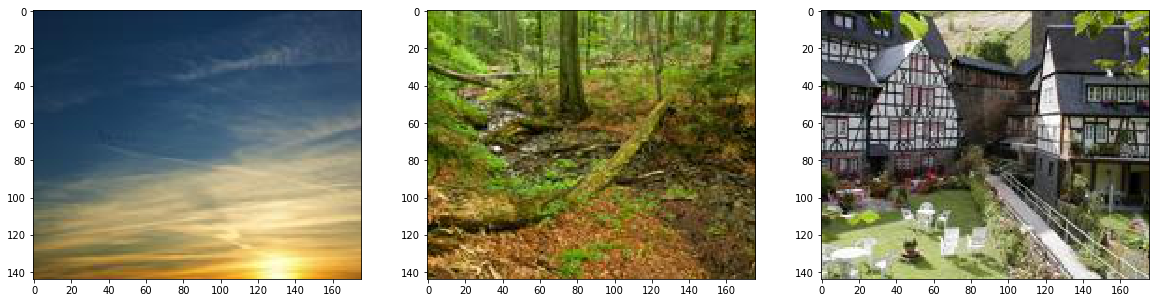

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [4]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.



## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

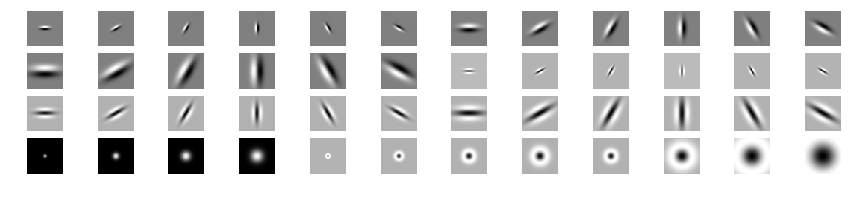

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1




The function `visualize_features(im,  filter_bank, n_filters=5)` recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


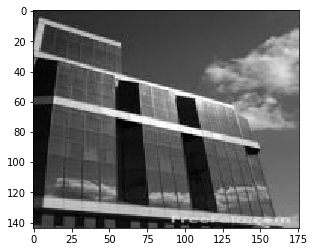

In [8]:
im = building_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

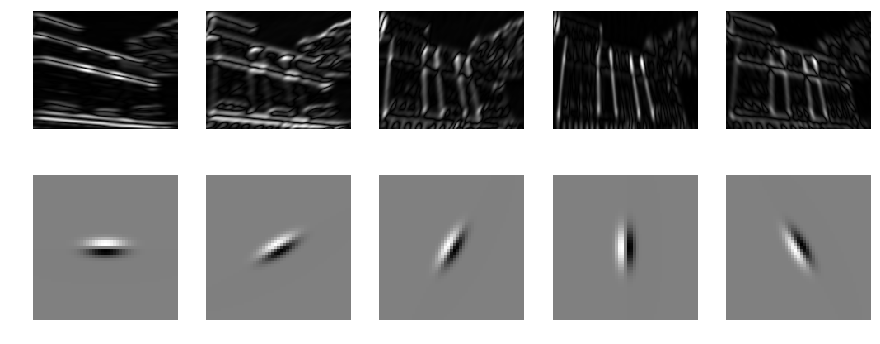

In [9]:
from scipy import ndimage

def visualize_features(im,  filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))

    for j in range(n_filters):
        
        ax[0,j].imshow(np.abs(ndimage.convolve(im, filter_bank[:,:,j])), cmap = 'gray')
        ax[0,j].axis("off")
        
        ax[1,j].imshow(filter_bank[:,:,j], cmap = 'gray')
        ax[1,j].axis("off")

visualize_features(im, filter_bank)



Given $D$ filters from the filter bank and a single image `image`, the function `features_from_filter_bank(image, filter_bank, n_filters)`  returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [10]:
im = skimage.color.rgb2gray(building_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):

    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
  
    for i in range(n_filters):
        features_for_im[i] = np.mean(np.abs(ndimage.convolve(image, filter_bank[:,:,i])))
    
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)



The function `get_class_Features(all_images, filter_bank)`  applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [11]:
all_images = building_images + forest_images + sunset_images

In [ ]:
%%time

def get_class_features(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,filter_bank.shape[-1]))

    for i in range(n_images):
        img = skimage.color.rgb2gray(all_images[i])
        all_feature_vectors[i] = features_from_filter_bank(img, filter_bank, n_filters)
    return all_feature_vectors

all_feature_vectors=get_class_features(all_images,  filter_bank)

In [273]:
np.save("matriu.npy",all_feature_vectors)

In [12]:
all_feature_vectors = np.load("matriu.npy")


The function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


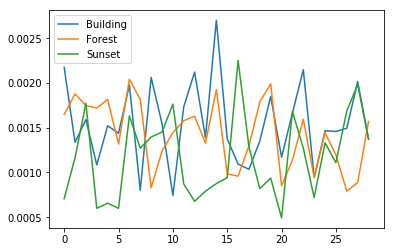

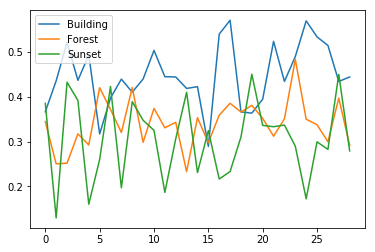

In [13]:
import matplotlib.pyplot as plt

def visualize_features(k, all_feature_vectors):
    
    plt.plot(all_feature_vectors[0:29,k])
    plt.plot(all_feature_vectors[30:59,k])
    plt.plot(all_feature_vectors[60:89,k])
    plt.legend(['Building', 'Forest', 'Sunset'], loc='upper left')
    plt.show()
    
    return None

visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)





#### Similarity search

Assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$




The function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` is the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.


In [14]:
from numpy.linalg import norm
def retrieve_k_images_from_X(query, X, k):
    #Complete
    distances = None
    closest_to_query = None
    closest_images = None
    llista = []
    
    for i in range(X.shape[0]):
        dist = np.sqrt(np.sum(np.power(query-X[i],2)))
        llista.append((dist,i))
        
    llista.sort()
    
    closest_images = [x[1] for x in llista[:k]]

    return closest_images

Text(0.5,1,'Sixth most similar')

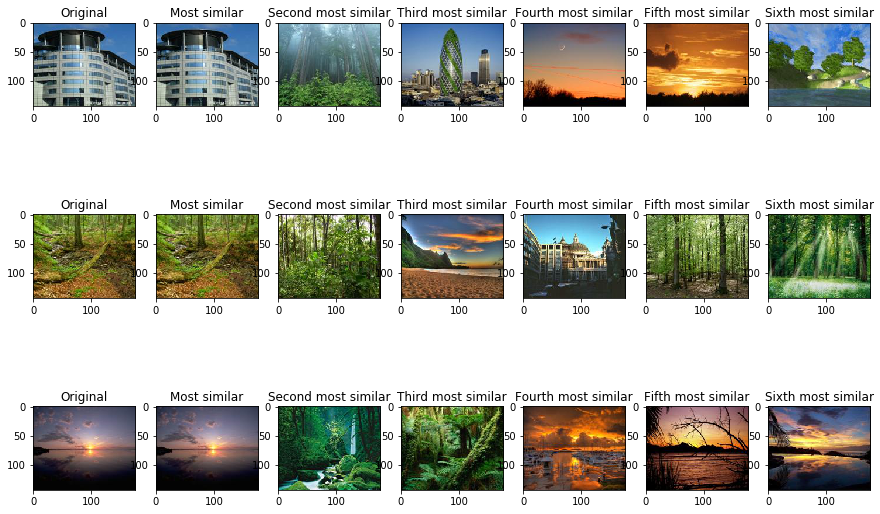

In [15]:
X = np.array(all_feature_vectors)

ind_1 = 6
ind_2 = 30
ind_3 = 65
k = 5

query_1 = X[ind_1, :]
query_2 = X[ind_2,:]
query_3 = X[ind_3,:]

a = retrieve_k_images_from_X(query_1, X, k+1)
b = retrieve_k_images_from_X(query_2, X, k+1)
c = retrieve_k_images_from_X(query_3, X, k+1)
# Display the query images

fig, ax = plt.subplots(ncols=7, nrows=3, figsize=(15,10))
ax[0,0].imshow(all_images[ind_1])
ax[0,0].set_title('Original')
ax[0,1].imshow(all_images[a[0]])
ax[0,1].set_title('Most similar')
ax[0,2].imshow(all_images[a[1]])
ax[0,2].set_title('Second most similar')
ax[0,3].imshow(all_images[a[2]])
ax[0,3].set_title('Third most similar')
ax[0,4].imshow(all_images[a[3]])
ax[0,4].set_title('Fourth most similar')
ax[0,5].imshow(all_images[a[4]])
ax[0,5].set_title('Fifth most similar')
ax[0,6].imshow(all_images[a[5]])
ax[0,6].set_title('Sixth most similar')

ax[1,0].imshow(all_images[ind_2]) 
ax[1,0].set_title('Original')
ax[1,1].imshow(all_images[b[0]]) 
ax[1,1].set_title('Most similar')
ax[1,2].imshow(all_images[b[1]])
ax[1,2].set_title('Second most similar')
ax[1,3].imshow(all_images[b[2]])
ax[1,3].set_title('Third most similar')
ax[1,4].imshow(all_images[b[3]])
ax[1,4].set_title('Fourth most similar')
ax[1,5].imshow(all_images[b[4]])
ax[1,5].set_title('Fifth most similar')
ax[1,6].imshow(all_images[b[5]])
ax[1,6].set_title('Sixth most similar')

ax[2,0].imshow(all_images[ind_3]) 
ax[2,0].set_title('Original')
ax[2,1].imshow(all_images[c[0]]) 
ax[2,1].set_title('Most similar')
ax[2,2].imshow(all_images[c[1]])
ax[2,2].set_title('Second most similar')
ax[2,3].imshow(all_images[c[2]])
ax[2,3].set_title('Third most similar')
ax[2,4].imshow(all_images[c[3]])
ax[2,4].set_title('Fourth most similar')
ax[2,5].imshow(all_images[c[4]])
ax[2,5].set_title('Fifth most similar')
ax[2,6].imshow(all_images[c[5]])
ax[2,6].set_title('Sixth most similar')


Retrieving the most similar image based on the information about color


1)  The function `get_rgb_Features(all_images)`  obtains the RGB information by applying `exposure.histogram(image,nbins=32)` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.

2)  Use the same function `retrieve_k_images_from_X(query, X, k)` where `query` is an image, `X` is the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image.


In [18]:
from skimage import exposure
from skimage import img_as_float

def get_rgb_Features(all_images):
    
    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors_rgb = np.zeros((n_images,96))

    for i in range(n_images):
        img = img_as_float(all_images[i])
        r = exposure.histogram(img[:,:,0],nbins=32)
        g = exposure.histogram(img[:,:,1],nbins=32)
        b = exposure.histogram(img[:,:,2],nbins=32)
        all_feature_vectors_rgb[i] = np.concatenate((r[0],g[0],b[0]))
        
    return all_feature_vectors_rgb

all_feature_vectors_rgb=get_rgb_Features(all_images)

Text(0.5,1,'Sixth most similar')

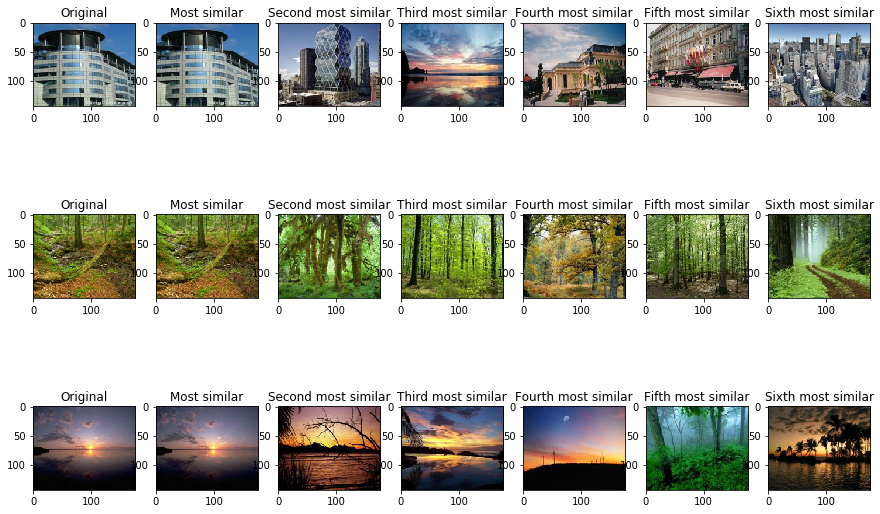

In [19]:
X_rgb = np.array(all_feature_vectors_rgb)

ind_1 = 6
ind_2 = 30
ind_3 = 65
k = 5

query_1 = X_rgb[ind_1, :]
query_2 = X_rgb[ind_2,:]
query_3 = X_rgb[ind_3,:]

a = retrieve_k_images_from_X(query_1, X_rgb, k+1)
b = retrieve_k_images_from_X(query_2, X_rgb, k+1)
c = retrieve_k_images_from_X(query_3, X_rgb, k+1)
# Display the query images

fig, ax = plt.subplots(ncols=7, nrows=3, figsize=(15,10))
ax[0,0].imshow(all_images[ind_1])
ax[0,0].set_title('Original')
ax[0,1].imshow(all_images[a[0]])
ax[0,1].set_title('Most similar')
ax[0,2].imshow(all_images[a[1]])
ax[0,2].set_title('Second most similar')
ax[0,3].imshow(all_images[a[2]])
ax[0,3].set_title('Third most similar')
ax[0,4].imshow(all_images[a[3]])
ax[0,4].set_title('Fourth most similar')
ax[0,5].imshow(all_images[a[4]])
ax[0,5].set_title('Fifth most similar')
ax[0,6].imshow(all_images[a[5]])
ax[0,6].set_title('Sixth most similar')

ax[1,0].imshow(all_images[ind_2]) 
ax[1,0].set_title('Original')
ax[1,1].imshow(all_images[b[0]]) 
ax[1,1].set_title('Most similar')
ax[1,2].imshow(all_images[b[1]])
ax[1,2].set_title('Second most similar')
ax[1,3].imshow(all_images[b[2]])
ax[1,3].set_title('Third most similar')
ax[1,4].imshow(all_images[b[3]])
ax[1,4].set_title('Fourth most similar')
ax[1,5].imshow(all_images[b[4]])
ax[1,5].set_title('Fifth most similar')
ax[1,6].imshow(all_images[b[5]])
ax[1,6].set_title('Sixth most similar')

ax[2,0].imshow(all_images[ind_3]) 
ax[2,0].set_title('Original')
ax[2,1].imshow(all_images[c[0]]) 
ax[2,1].set_title('Most similar')
ax[2,2].imshow(all_images[c[1]])
ax[2,2].set_title('Second most similar')
ax[2,3].imshow(all_images[c[2]])
ax[2,3].set_title('Third most similar')
ax[2,4].imshow(all_images[c[3]])
ax[2,4].set_title('Fourth most similar')
ax[2,5].imshow(all_images[c[4]])
ax[2,5].set_title('Fifth most similar')
ax[2,6].imshow(all_images[c[5]])
ax[2,6].set_title('Sixth most similar')



```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

Takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).





In [20]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [21]:
def accuracy(X, class_labels, k, query, class_query):
    
    query_img = X[query, :]
    
    a = retrieve_k_images_from_X(query_img, X, k+1)
    
    suma = 0
    
    for i in a:
        if i != query:
            if class_labels[i]==class_query:
                suma += 1
    return suma/k


image = 6
class_ = 0
k = 4

accuracy(X,class_labels,k,image,class_)

0.25

It does match. As an example, querying the 6th image (class 0), we can see that only one image belongs to the same class

Text(0.5,1,'Fourth most similar')

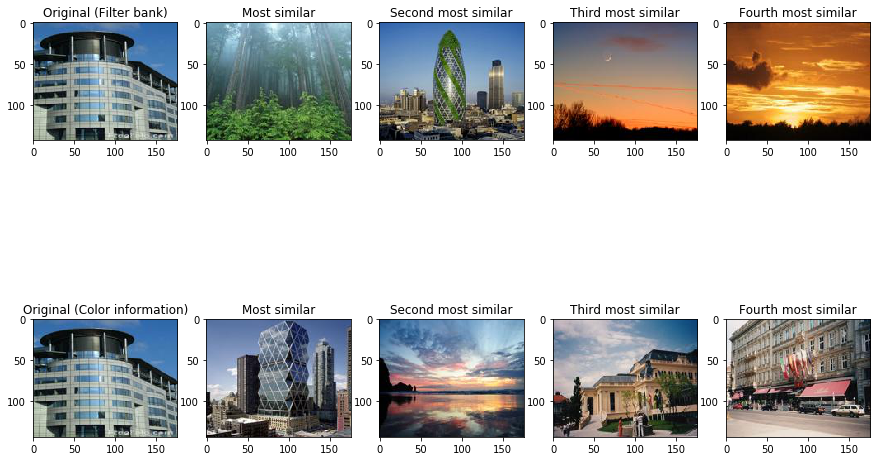

In [22]:
query_img = X[image, :]
query_img_rgb = X_rgb[image, :]

a = retrieve_k_images_from_X(query_img, X, k+1)
b = retrieve_k_images_from_X(query_img_rgb, X_rgb, k+1)
# Display the query images

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15,10))
ax[0,0].imshow(all_images[image])
ax[0,0].set_title('Original (Filter bank)')
ax[0,1].imshow(all_images[a[1]])
ax[0,1].set_title('Most similar')
ax[0,2].imshow(all_images[a[2]])
ax[0,2].set_title('Second most similar')
ax[0,3].imshow(all_images[a[3]])
ax[0,3].set_title('Third most similar')
ax[0,4].imshow(all_images[a[4]])
ax[0,4].set_title('Fourth most similar')

ax[1,0].imshow(all_images[image])
ax[1,0].set_title('Original (Color information)')
ax[1,1].imshow(all_images[b[1]])
ax[1,1].set_title('Most similar')
ax[1,2].imshow(all_images[b[2]])
ax[1,2].set_title('Second most similar')
ax[1,3].imshow(all_images[b[3]])
ax[1,3].set_title('Third most similar')
ax[1,4].imshow(all_images[b[4]])
ax[1,4].set_title('Fourth most similar')

- Compute the accuracy for both cases, when X is obtained by (A) applying the bank of filters or (B) the color information.



In [23]:
print("Accuracy with filter bank: ",accuracy(X,class_labels,k,image,class_))
print("Accuracy with color information: ",accuracy(X_rgb,class_labels,k,image,class_))

Accuracy with filter bank:  0.25
Accuracy with color information:  0.75



The function ` lm_features_rgb(image, filter_bank)`  returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [24]:
def lm_features_rgb(image, filter_bank):

    n_filters = filter_bank.shape[-1]
    #im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(n_filters*3)

    
    for i in range(n_filters):
        j = i*3
        features_for_im[j] = np.mean(np.abs(ndimage.convolve(image[:,:,0], filter_bank[:,:,i])))
        features_for_im[j+1] = np.mean(np.abs(ndimage.convolve(image[:,:,1], filter_bank[:,:,i])))
        features_for_im[j+2] = np.mean(np.abs(ndimage.convolve(image[:,:,2], filter_bank[:,:,i])))

        
    return features_for_im


Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.


In [25]:
%%time

def all_lm_features_rgb(all_images, filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    
    all_feature_vectors=np.zeros((n_images,n_filters*3))
    
    for i in range(n_images):
        all_feature_vectors[i] = lm_features_rgb(all_images[i], filter_bank)  

    return all_feature_vectors

X_lm_rgb = all_lm_features_rgb(all_images, filter_bank)

CPU times: user 23min 47s, sys: 1min 13s, total: 25min
Wall time: 27min 37s


In [26]:
np.save("x_lm_rgb.npy",X_lm_rgb)

In [25]:
X_lm_rgb = np.load("x_lm_rgb.npy")

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

##Multithread not working properly

def all_lm_features_rgb(all_images,filter_bank):

    all_images = arg[0]
    filter_bank = arg[1]
    n_images = len(all_images)
    n_filters = len(filter_bank)
    
    all_feature_vectors=np.zeros((n_images,len(filter_bank)*3))
    
    for i in range(n_images):
        print(all_images[i].shape)
        #q = Parallel(n_jobs=1,max_nbytes=None)(map(delayed(lm_features_rgb), all_images[i], filter_bank))
        #pool = multiprocessing.Pool()
        
        #args = (all_images[i], filter_bank)
        #q = pool.map(lm_features_rgb, args)
        
        print(len(q))
        
        all_feature_vectors[i] = q
        
    return all_feature_vectors


X_lm_rgb = all_lm_features_rgb(all_images, filter_bank)


- Is the accuracy higher using lm_features?

In [26]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)

[6, 19, 8, 27, 44]


Text(0.5,1,'Fourth most similar')

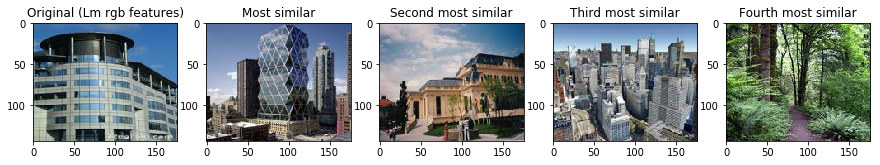

In [28]:
image = 6
class_ = 0
k = 4

query_img_lm = X_lm_rgb[image, :]

a = retrieve_k_images_from_X(query_img_lm, X_lm_rgb, k+1)

fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,10))
ax[0].imshow(all_images[image])
ax[0].set_title('Original (Lm rgb features)')
ax[1].imshow(all_images[a[1]])
ax[1].set_title('Most similar')
ax[2].imshow(all_images[a[2]])
ax[2].set_title('Second most similar')
ax[3].imshow(all_images[a[3]])
ax[3].set_title('Third most similar')
ax[4].imshow(all_images[a[4]])
ax[4].set_title('Fourth most similar')

In [29]:
print("Accuracy with lm rgb features: ",accuracy(X_lm_rgb,class_labels,k,image,class_))

Accuracy with lm rgb features:  0.75
